# Monte Carlo Simulation of Temperature for Weather Derivative Pricing

## Modified mean-reverting Ornstein-Uhlenbeck (OU) process

The model choose is the Modified Mean-Reverting Ornstein-Uhlenbeck (OU) process:

$$ dT_{t} = [\tilde{dT_{t}} / dt + 0.438(\tilde{T_{t}} - T_{t})]dt + \sigma_{t}W_{t} $$

Where our changing average Daily Average Temperature (DAT) is:

$$ \tilde{T_{t}} = 16.8 + (3.32e - 05)t + 5.05sin((2\pi / 365.25)t + 1.27)$$

So the derivative of the model is:

$$ \tilde{T_{t}}' = (3.32e - 05)t + 5.05(2\pi / 365.25)cos((2\pi / 365.25)t + 1.27)$$

In [1]:
import os 
import numpy as np
import pandas as pd
import datetime as dt
from scipy import interpolate

In [2]:
import glob

df_list_max = []
df_list_min = []
list_of_files = glob.glob('./Data/*.csv')
for file in list_of_files:
    temp = pd.read_csv(file)
    if file.find("IDCJAC0010") != -1:
        temp = temp.iloc[290:] if file.find("66214") != -1 else temp.iloc[:57999]
        df_list_max.append(temp)
    else:
        temp = temp.iloc[291:] if file.find("66214") != -1 else temp.iloc[:58000]
        df_list_min.append(temp)

In [3]:
df_max = pd.concat(df_list_max)
df_min = pd.concat(df_list_min)

In [4]:
from datetime import datetime
def traf_datetime(row):
    return datetime(row.Year,row.Month,row.Day)

In [5]:
df_max['Date'] = df_max.apply(traf_datetime,axis=1)
df_min['Date'] = df_min.apply(traf_datetime,axis=1)

df_max.set_index('Date', inplace=True)
df_min.set_index('Date', inplace=True)

drop_cols = [0,1,2,3,4,6,7]

df_max.drop(df_max.columns[drop_cols],axis=1,inplace=True)
df_min.drop(df_min.columns[drop_cols],axis=1,inplace=True)

df_max.rename(columns={'Maximum temperature (Degree C)':'Tmax'}, inplace=True)
df_min.rename(columns={'Minimum temperature (Degree C)':'Tmin'}, inplace=True)

In [6]:
df = pd.merge(df_max, df_min, how='inner', on=['Date'])

def avg_temp(row):
    return (row.Tmax + row.Tmin)/2

df['T'] = df.apply(avg_temp, axis=1)

df = df.dropna()

del df_min, df_max

In [7]:
temp_t = df['T'].copy(deep=True)
temp_t = temp_t.to_frame()
temp_t.head()

,T
Date,
2017-10-18,21.90
2017-10-19,21.85
2017-10-20,19.10
2017-10-21,16.15
2017-10-22,18.25


<AxesSubplot:xlabel='Date'>

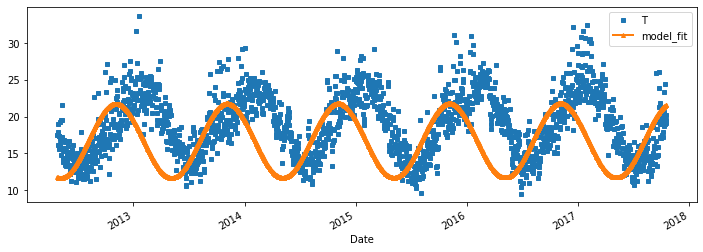

In [8]:
# Modified mean-reverting Ornstein-Uhlenbeck

if isinstance(temp_t.index , pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index=temp_t.index.map(dt.datetime.toordinal)
    
def T_model(x, a, b, alpha, theta):
    omega = 2*np.pi/365.25
    T = a + b*x + alpha*np.sin(omega*x + theta)
    return T
def dT_model(x, a, b, alpha, theta):
    omega=2*np.pi/365.25
    dT =  b + alpha*omega*np.cos(omega*x + theta)
    return dT

Tbar_params = [16.8, 3.32e-05, 5.05, 1.27]
temp_t['model_fit'] = T_model(temp_t.index-first_ord, *Tbar_params)
if not isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)
temp_t[-2000:].plot(figsize=(12,4), style=['s','^-','k--'] , markersize=4, linewidth=2 )

## Volatility of Temperature Process

The volatility estimator is based on the quadratic variation $\sigma_{t}^{2}$ of the temperature process $T_{t}$.

$$ \hat{\sigma_{t}}^2 = 1/N_{t} \sum_{i=0}^{N-1} (T_{i+1} - T_{i})^{2} $$

In [11]:
temp_vol = df['T'].copy(deep=True)
temp_vol = temp_vol.to_frame()
temp_vol['day'] = temp_vol.index.dayofyear
temp_vol['month'] = temp_vol.index.month

vol = temp_vol.groupby(['day'])['T'].agg(['mean','std'])
days = np.array(vol['std'].index)
T_std = np.array(vol['std'].values)

In [12]:
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    t, c, k = interpolate.splrep(x, y, t=np.quantile(x, x_new), s=3)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

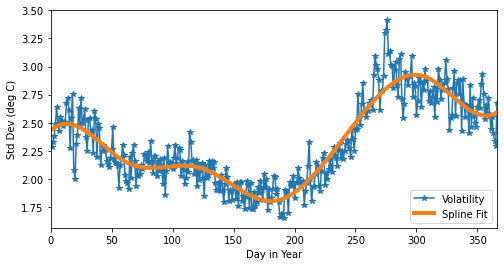

In [15]:
import matplotlib.pyplot as plt

volatility = spline(5, days, T_std)
plt.figure(figsize=(8,4))
plt.plot(days, T_std, marker='*',label='Volatility')
plt.plot(days, volatility, linewidth=4, label='Spline Fit')
plt.ylabel('Std Dev (deg C)')
plt.xlabel('Day in Year')
plt.xlim(0,366) 
plt.legend(loc='lower right')
plt.show()

## Monte Carlo Simulation of Temperature Paths:

We defined a Euler scheme approximation:

$$ T_{i+1} = T_{i} + \tilde{T_{i}^{'}} + k(\tilde{T_{i}} - T_{i}) + \sigma_{i}z_{i} $$ 

In [16]:
def euler_step(row, kappa, M):
    """Function for euler scheme approximation step in 
    modified OH dynamics for temperature simulations
    Inputs: 
    - dataframe row with columns: T, Tbar, dTbar and vol
    - kappa: rate of mean reversion
    Output:
    - temp: simulated next day temperatures
    """
    if row['Tbar_shift'] != np.nan:
        T_i = row['Tbar']
    else:
        T_i = row['Tbar_shift']  
    T_det = T_i + row['dTbar']
    T_mrev =  kappa*(row['Tbar'] - T_i)
    sigma = row['vol']*np.random.randn(M)
    return T_det + T_mrev + sigma

In [17]:
def monte_carlo_temp(trading_dates, Tbar_params, vol_model, first_ord, M=1, kappa=0.438):
    """Monte Carlo simulation of temperature
    Inputs:
    - trading_dates: pandas DatetimeIndex from start to end dates
    - M: number of simulations
    - Tbar_params: parameters used for Tbar model
    - vol_model: fitted volatility model with days in year index
    - first_ord: first ordinal of fitted Tbar model
    Outputs:
    - mc_temps: DataFrame of all components individual components
    - mc_sims: DataFrame of all simulated temerpature paths
    """
    if isinstance(trading_dates, pd.DatetimeIndex):
        trading_date=trading_dates.map(dt.datetime.toordinal)
      
    # Use Modified Ornstein-Uhlenbeck process with estimated parameters to simulate Tbar DAT 
    Tbars = T_model(trading_date-first_ord, *Tbar_params) 
    
    # Use derivative of modified OH process SDE to calculate change of Tbar
    dTbars = dT_model(trading_date-first_ord, *Tbar_params) 
    
    # Create DateFrame with thi
    mc_temps = pd.DataFrame(data=np.array([Tbars, dTbars]).T,
                            index=trading_dates, columns=['Tbar','dTbar'])
    
    # Create columns for day in year
    mc_temps['day'] = mc_temps.index.dayofyear
    
    # Apply BSpline volatility model depending on day of year 
    mc_temps['vol'] = vol_model[mc_temps['day']-1]
    # Shift Tbar by one day (lagged Tbar series)
    mc_temps['Tbar_shift'] = mc_temps['Tbar'].shift(1)  
    
    # Apply Euler Step Pandas Function
    data = mc_temps.apply(euler_step, args=[kappa, M], axis=1)
    
    # Create final DataFrame of all simulations
    mc_sims = pd.DataFrame(data=[x for x in [y for y in data.values]], 
                 index=trading_dates,columns=range(1,M+1))
    
    return mc_temps, mc_sims

## Simulation of Temperature 

Here we finally simulate temperature under the Physical probability measure P

In [21]:
no_sims = 5
trading_dates = pd.date_range(start='2022-08-07', end='2025-08-31',freq='D')
mc_temps, mc_sims = monte_carlo_temp(trading_dates, Tbar_params, volatility, first_ord, no_sims)

In [22]:
mc_temps

,Tbar,dTbar,day,vol,Tbar_shift
2022-08-07,16.995197,0.086873,219,2.075105,NaN
2022-08-08,17.082046,0.086820,220,2.087545,16.995197
2022-08-09,17.168828,0.086741,221,2.100151,17.082046
2022-08-10,17.255519,0.086636,222,2.112914,17.168828
2022-08-11,17.342092,0.086506,223,2.125826,17.255519
...,...,...,...,...,...
2025-08-27,18.747187,0.080853,239,2.346302,18.666064
2025-08-28,18.827763,0.080293,240,2.360546,18.747187
2025-08-29,18.907766,0.079710,241,2.374796,18.827763
2025-08-30,18.987174,0.079102,242,2.389046,18.907766


In [23]:
mc_sims

,1,2,3,4,5
2022-08-07,17.590846,19.733844,18.001963,16.362409,16.417905
2022-08-08,17.129626,17.303431,16.229298,15.403724,16.319610
2022-08-09,18.539292,19.152954,13.907391,15.633393,16.230988
2022-08-10,20.599218,16.798116,20.130090,15.783562,17.761549
2022-08-11,18.710074,19.252404,19.934016,17.359080,19.741483
...,...,...,...,...,...
2025-08-27,19.143140,19.079281,21.052112,18.949247,20.626015
2025-08-28,20.521332,21.592911,19.184170,19.981746,21.992396
2025-08-29,22.525454,19.168650,17.530470,17.410706,19.532692
2025-08-30,23.908511,17.093818,17.337060,20.169465,17.512600


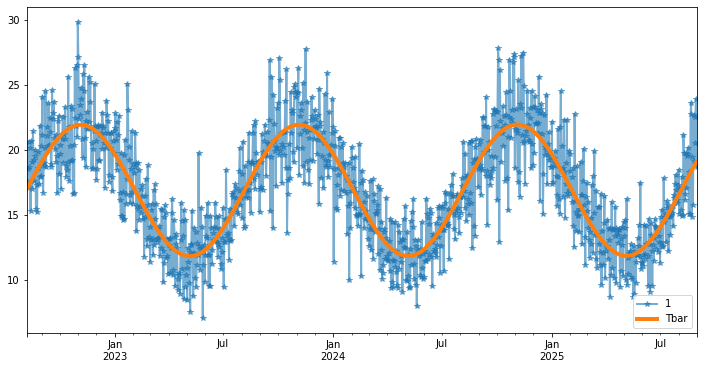

In [24]:
plt.figure(figsize=(12,6))
mc_sims[1].plot(alpha=0.6,linewidth=2, marker='*')
mc_temps["Tbar"].plot(linewidth=4)
plt.legend(loc='lower right')
plt.show()

## Temperature Distributions

Let’s finally observe the difference between our monte carlo temperature simulations distribution between the peaks of summer and winter days.

Here we simulate 10,000 temperatures on 1st July, 2023 for Winter and 1st Jan, 2023 for a representation of peak Summer temps and volatility.

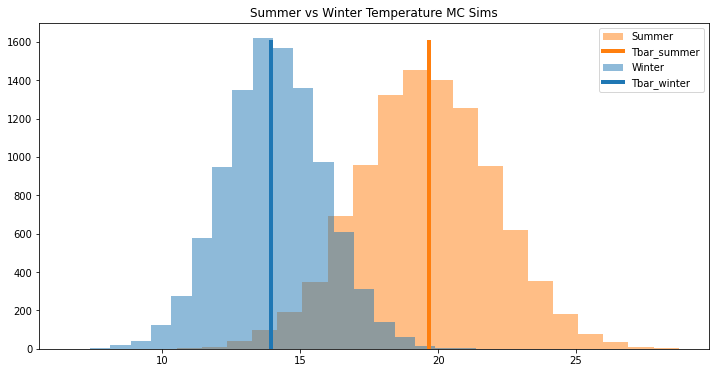

In [25]:
no_sims = 10000
trading_dates_winter = pd.date_range(start='2023-07-01', end='2023-07-01', freq='D')
mc_temps_winter, mc_sims_winter = monte_carlo_temp(trading_dates_winter, Tbar_params, volatility, first_ord, no_sims)

trading_dates_summer = pd.date_range(start='2023-01-01', end='2023-01-01', freq='D')
mc_temps_summer, mc_sims_summer = monte_carlo_temp(trading_dates_summer, Tbar_params, volatility, first_ord, no_sims)

plt.figure(figsize=(12,6))
plt.title('Winter vs Summer Temperature MC Sims')

Tbar_summer = mc_temps_summer.iloc[-1,:]['Tbar']
Tbar_winter = mc_temps_winter.iloc[-1,:]['Tbar']

plt.hist(mc_sims_summer.iloc[-1,:],bins=20, alpha=0.5, label='Summer', color='tab:orange')
plt.plot([Tbar_summer,Tbar_summer],[0,1600], linewidth=4, label='Tbar_summer', color='tab:orange')
plt.title('Summer vs Winter Temperature MC Sims')

plt.hist(mc_sims_winter.iloc[-1,:],bins=20, alpha=0.5, label='Winter', color='tab:blue')
plt.plot([Tbar_winter,Tbar_winter],[0,1600], linewidth=4, label='Tbar_winter', color='tab:blue')
plt.legend()
plt.show()